# Land-Use-Change (LUC) Emissions from Animal Feed & Pasture (2018–2022)

We combine:

1. **FAOSTAT "Crops and Livestock" (SCL)** data — to estimate, for each crop:
   > *What fraction of its domestic use is fed to animals (feed share)?*
2. **Singh et al. (2024)** trade-linked deforestation / land-use-change (LUC) emissions — to know, for each commodity:
   > *How much LUC CO₂ is caused by consumption in each country, and where the LUC occurs (producer)?*

Then we isolate the part of **LUC due to animal farming**:

- **Feed crops** (soybeans, rapeseed, sunflower seed, maize, barley, sorghum), and
- **Pasture / grazing** (ruminant/cattle/beef land expansion).

Finally, we group flows by **who consumes** and **where LUC occurs**:

- Global North (GN)
- China (CN)
- Global South (GS, ex-China)

and plot flows such as:

- GN → GS (Global North demand causing LUC in the Global South)
- GS → GN
- CN → GS

## 0. Files and environment

In [1]:
%matplotlib inline
import sys, platform
import pandas as pd, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", mpl.__version__)

Python: 3.10.14
Platform: macOS-13.6.6-arm64-arm-64bit
pandas: 2.2.2
numpy: 1.26.4
matplotlib: 3.9.1


In [2]:
from pathlib import Path

# Input/output directories
IN_DIR  = Path("data")
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

FAO_FILE   = IN_DIR / "FAOSTAT_crops_feed_data.csv"
SINGH_FILE = IN_DIR / "Singh et al 2024 - Commodity-driven deforestation, carbon emissions & trade 2018-2022.xlsx"

print(f"FAOSTAT file: {FAO_FILE}")
print(f"Singh file:   {SINGH_FILE}")
print(f"Output dir:   {OUT_DIR}")


FAOSTAT file: data/FAOSTAT_crops_feed_data.csv
Singh file:   data/Singh et al 2024 - Commodity-driven deforestation, carbon emissions & trade 2018-2022.xlsx
Output dir:   outputs


## 1. Region groups (Global North, China, Global South)

We follow the same GN / CN / GS country grouping used in the EXIOBASE per-capita
analysis to ensure full consistency across datasets:

- **Global North (GN):** high-income Europe, North America, Oceania,
  Japan, Republic of Korea, Taiwan.

- **China (CN):** China / China, mainland.

- **Global South (GS):** all remaining countries (including Singapore,
  Israel, Saudi Arabia, Brazil, India, Indonesia, etc.).

*Note:* EXIOBASE does not classify Singapore or Israel as part of the
Global North. To maintain a consistent GN / CN / GS mapping between the
EXIOBASE and FAOSTAT/Singh datasets, we assign both Singapore and Israel
to the **Global South** in the LUC analysis. These adjustments affect
only a very small number of countries and have **no material impact**
on the overall regional patterns of land-use-change (LUC) emissions.


In [3]:
GN_NAMES = {
    "Australia","Austria","Belgium","Bulgaria","Canada","Switzerland","Cyprus","Czechia","Germany","Denmark",
    "Spain","Estonia","Finland","France","United Kingdom of Great Britain and Northern Ireland","Greece","Croatia",
    "Hungary","Ireland","Iceland","Italy","Liechtenstein","Lithuania","Luxembourg","Latvia","Malta","Netherlands",
    "Norway","Poland","Portugal","Romania","Slovakia","Slovenia","Sweden","United States of America",
    "Japan","Republic of Korea","Taiwan (Province of China)","New Zealand"
}


def region_from_name(name: str) -> str:
    """
    Map a FAO / Singh country name to region groups:
    
    - 'CN' for China / China, mainland
    - 'GN' for countries listed in GN_NAMES
    - 'GS' for all others (Global South)
    
    Example:
      - 'Saudi Arabia' → 'GS'
      - 'United States of America' → 'GN'
      - 'China, mainland' → 'CN'
    """
    import pandas as pd
    if pd.isna(name) or not str(name).strip():
        return "UNK"
    if name in ("China","China, mainland"):
        return "CN"
    return "GN" if name in GN_NAMES else "GS"

# Name harmonisation for Singh → FAOSTAT style
NAME_FIX = {
    "China":"China, mainland",
    "United Kingdom":"United Kingdom of Great Britain and Northern Ireland",
    "Cote d'Ivoire":"Côte d'Ivoire",
    "Vietnam":"Viet Nam",
    "Russia":"Russian Federation",
    "Iran":"Iran (Islamic Republic of)",
    "Syria":"Syrian Arab Republic",
    "Turkey":"Türkiye",
    "Bolivia":"Bolivia (Plurinational State of)",
    "Congo, Rep.":"Congo",
    "Congo, Dem. Rep.":"Democratic Republic of the Congo",
}

## 2. Feed crops and oilseed cakes

We include two types of feed materials:

1. **Cereals used directly as grain feed:**  
   Maize, Barley, Sorghum  
2. **Oilseeds and their cakes (meals):**  
   Soybeans, Rapeseed, Sunflower seed  
   Cake of soybeans, Cake of rapeseed, Cake of sunflower seed

Cereals are fed directly as grain; therefore, their feed tonnages are used **as reported** in FAOSTAT with no conversion.  

Oilseed cakes (meals), however, are by-products of oil extraction and represent only a fraction of the original seed mass. To make all feed materials comparable on a **seed-equivalent basis**, we convert cake tonnages using typical crushing yields.

Let $y_{\mathrm{meal}}$ denote the fraction of seed mass that remains as meal after crushing.

Based on industry-reported crushing statistics and feed-processing references  
(e.g., United Soybean Board “SoyStats” for soybeans; Feedipedia technical profiles for rapeseed and sunflower seed), typical meal yields fall within:

- **Soybeans:** 78–82% of seed mass remains as meal (we apply $y_{\mathrm{meal}} = 0.80$)  
- **Rapeseed:** 55–62% of seed mass remains as meal (we apply $y_{\mathrm{meal}} = 0.61$)  
- **Sunflower seed:** 55–60% of seed mass remains as meal (we apply $y_{\mathrm{meal}} = 0.59$)

These values represent central industrial averages reflecting oil content, hull fraction, and extraction method (pressing/solvent).

Cake-to-seed conversion is then:

Seed-equivalent conversion for soybean cake:

**Seed-equivalent conversion for soybean cake:**

SeedEq_Feed(c,t,Soybeans) = Cake_Feed_tonnes(c,t,Soybean_cake) / y_meal(Soybeans)



For example, 800 t of soybean cake corresponds to  
\( 800 / 0.80 = 1000 \) t of seed-equivalent soybeans.

For cereals (maize, barley, sorghum), no conversion is applied:
feed tonnages are already in seed-equivalent units.


In [4]:
FEED_CROP_MAP = {
    "soybeans": "Soybeans", "soya beans": "Soybeans", "soyabeans": "Soybeans",
    "rapeseed": "Rapeseed", "rape or colza seed": "Rapeseed", "canola": "Rapeseed",
    "sunflower seed": "Sunflower seed", "sunflower seeds": "Sunflower seed", "sunflower": "Sunflower seed",
    "maize": "Maize", "maize (corn)": "Maize", "corn": "Maize",
    "barley": "Barley", "sorghum": "Sorghum",
}

# Set of crops treated as "feed crops" in Singh's LUC table
FEED_SET = {"Soybeans","Rapeseed","Sunflower seed","Maize","Barley","Sorghum"}

# Pasture component: ruminant meat (beef/cattle/ruminants) in Singh
PASTURE_SET = {"RUMINANT_MEAT"}

# Oilseed cake → seed mapping for FAOSTAT
CAKE_TO_SEED = {
    "Soybean cake":        "Soybeans",
    "Rapeseed cake":       "Rapeseed",
    "Sunflower seed cake": "Sunflower seed",
}

# Meal yield: tonnes of cake per tonne of seed input (approximate crushing ratios).
# These are standard approximate values from feed / oil-processing industry data & LCA databases.
MEAL_YIELD = {
    "Soybeans":       0.80,  # 1 t seed → ~0.80 t meal + ~0.20 t oil
    "Rapeseed":       0.61,
    "Sunflower seed": 0.59,
}

## 3. FAOSTAT: compute global feed shares per crop

FAOSTAT SCL provides, for each **country $c$**, **crop $i$**, and **year $t$**:

- `Item` – the commodity name (Soybeans, Maize, Cake of soya beans, …)  
- `Element` – the use category (Feed, Food, Seed, Processing, Loss, Other uses (non-food), Residuals, …)  
- `Value` – the quantity, in **tonnes per year**

We use FAOSTAT **only** to compute feed shares for each crop.  
Cereals (maize, barley, sorghum) enter directly as grain feed, while oilseed cakes are first converted to seed-equivalent tonnes using the crushing yields described in Section 2.

For each crop, the feed share is defined as:

$$
\text{feed share}_{c,i,t}
= \frac{\text{tonnes used as Feed (seed or cake-equivalent)}}
{\text{total domestic use of that crop (all elements)}}
$$

Total domestic use is defined as the **sum of all FAOSTAT utilization elements in tonnes**  
(Food + Feed + Processing + Seed + Loss + Other uses + Residuals).

We then average feed shares across countries $c$ and years 2018–2022 to obtain **one global feed share per crop**.

**Example interpretation:**

- Barley: 0.491 → about **49% of barley domestic use** goes into animal feed  
- Soybeans: 0.829 → about **83% of soybean domestic use** goes into animal feed (primarily via cakes)

We do **not** use FAOSTAT to determine trade direction.  
All bilateral trade routing (who buys from whom) comes from Singh et al. (2024).


In [5]:
fa = pd.read_csv(FAO_FILE, low_memory=False)
fa = fa.rename(columns={c: c.strip() for c in fa.columns})
cols = {c.lower(): c for c in fa.columns}

AREA   = cols.get("area")
ITEM   = cols.get("item") or cols.get("items")
ELEM   = cols.get("element") or cols.get("elements")
UNIT   = cols.get("unit") or cols.get("units")
YEAR   = cols.get("year") or cols.get("time")
VALUE  = cols.get("value") or cols.get("values")

# Keep only mass units (t, tonnes, 1000 t). Ignore kcal or per-capita indicators.
if UNIT in fa.columns:
    u = fa[UNIT].astype(str).str.strip().str.lower()
    fa = fa[u.isin({"t","tonnes","1000 t"}) | fa[UNIT].isna()].copy()

# Numeric year/value; restrict to years of interest
fa[YEAR]  = pd.to_numeric(fa[YEAR], errors="coerce")
fa[VALUE] = pd.to_numeric(fa[VALUE], errors="coerce").fillna(0.0)
fa = fa[fa[YEAR].between(2018, 2022)]

def canon_item_fao(s: str):
    """
    Collapse FAOSTAT Item names to a small canonical set used here.
    This avoids multiple spellings (e.g. 'Soya beans', 'Soybeans').
    """
    s0 = str(s).strip().lower().replace("  ", " ")
    # Seeds
    if s0 in {"soybeans","soya beans","soyabeans"}: return "Soybeans"
    if s0 in {"rape or colza seed","rapeseed"}:     return "Rapeseed"
    if s0 in {"sunflower seed","sunflower"}:        return "Sunflower seed"
    if s0 in {"maize","maize (corn)","corn"}:       return "Maize"
    if s0 == "barley":                              return "Barley"
    if s0 == "sorghum":                             return "Sorghum"
    # Cakes (oilseed meals)
    if "cake of soya beans" in s0 or "soybean cake" in s0:                        return "Soybean cake"
    if "cake of rapeseed" in s0 or "cake of rape" in s0 or "rapeseed cake" in s0: return "Rapeseed cake"
    if "cake of sunflower" in s0 or "sunflower seed cake" in s0:                  return "Sunflower seed cake"
    return None

def canon_elem(e: str):
    """
    Map FAOSTAT Element into a small standard set.
    We mainly care about 'Feed' for the numerator, and we sum *all* elements
    (Food+Feed+Processed+Seed+Loss+Other uses+Residuals) for total domestic use.
    """
    s = str(e).strip().lower()
    if s.startswith("food supply quantity"):  return "Food"
    if s == "feed":                           return "Feed"
    if s == "seed":                           return "Seed"
    if s == "loss":                           return "Loss"
    if s == "other uses (non-food)":          return "Other uses (non-food)"
    if s in {"processed","processing"}:       return "Processed"
    if s == "residuals":                      return "Residuals"
    return None

fa["Item_std"]    = fa[ITEM].apply(canon_item_fao)
fa["Element_std"] = fa[ELEM].apply(canon_elem)

# Keep only rows whose Item & Element we understand
fa = fa[fa["Item_std"].notna() & fa["Element_std"].notna()].copy()

# --- Denominator: total domestic use per (country, crop, year) ---
seed_items = {"Soybeans","Rapeseed","Sunflower seed","Maize","Barley","Sorghum"}
den = (
    fa[fa["Item_std"].isin(seed_items)]
    .groupby([AREA,"Item_std",YEAR], as_index=False)[VALUE].sum()
    .rename(columns={VALUE:"DomesticUse_total_t"})
)

# --- Numerator for cereals (Maize, Barley, Sorghum): direct 'Feed' element in tonnes ---
feed_cereals = (
    fa[(fa["Item_std"].isin({"Maize","Barley","Sorghum"})) & (fa["Element_std"].eq("Feed"))]
    .groupby([AREA,"Item_std",YEAR], as_index=False)[VALUE].sum()
    .rename(columns={VALUE:"Feed_t"})
)

# --- Numerator for oilseeds (Soybeans, Rapeseed, Sunflower seed):
#     1) take 'Feed' element for cakes, 2) convert to seed-equivalent using MEAL_YIELD.
feed_cakes = (
    fa[(fa["Item_std"].isin(CAKE_TO_SEED.keys())) & (fa["Element_std"].eq("Feed"))]
    .groupby([AREA,"Item_std",YEAR], as_index=False)[VALUE].sum()
    .rename(columns={VALUE: "Cake_Feed_t"})
)

if not feed_cakes.empty:
    feed_cakes["SeedItem"] = feed_cakes["Item_std"].map(CAKE_TO_SEED)
    # SeedEq_Feed_t(c, SeedItem, t) = Cake_Feed_t(c, cake, t) / MEAL_YIELD(SeedItem)
    feed_cakes["SeedEq_Feed_t"] = feed_cakes.apply(
        lambda r: r["Cake_Feed_t"] / MEAL_YIELD.get(r["SeedItem"], np.nan),
        axis=1,
    )
    feed_cakes_seed = (
        feed_cakes[[AREA, "SeedItem", YEAR, "SeedEq_Feed_t"]]
        .rename(columns={"SeedItem": "Item_std"})
    )
else:
    feed_cakes_seed = pd.DataFrame(columns=[AREA, "Item_std", YEAR, "SeedEq_Feed_t"])

# Merge denominator and numerators
shares = (
    den
    .merge(feed_cereals,    on=[AREA, "Item_std", YEAR], how="left")
    .merge(feed_cakes_seed, on=[AREA, "Item_std", YEAR], how="left")
)
shares[["Feed_t", "SeedEq_Feed_t"]] = shares[["Feed_t", "SeedEq_Feed_t"]].fillna(0.0)

def feed_share_row(r):
    """
    Compute feed share for each country × crop × year.
    
    For cereals (Maize, Barley, Sorghum):
        feed_share = Feed_t / DomesticUse_total_t
    
    For oilseeds (Soybeans, Rapeseed, Sunflower seed):
        feed_share = SeedEq_Feed_t / DomesticUse_total_t
    """
    total = r["DomesticUse_total_t"]
    if total <= 0:
        return np.nan
    if r["Item_std"] in {"Maize","Barley","Sorghum"}:
        return r["Feed_t"] / total
    if r["Item_std"] in {"Soybeans","Rapeseed","Sunflower seed"}:
        return r["SeedEq_Feed_t"] / total
    return np.nan

shares["feed_share"] = shares.apply(feed_share_row, axis=1).clip(0, 1)

# Global average feed share per crop, 2018–2022
global_feed_by_crop = (
    shares.groupby("Item_std", as_index=False)["feed_share"]
    .mean()
    .set_index("Item_std")["feed_share"]
    .to_dict()
)

print("Global feed shares (2018–2022) from FAOSTAT:")
for k in ["Barley","Maize","Sorghum","Soybeans","Rapeseed","Sunflower seed"]:
    print(f"  {k:14s}: {global_feed_by_crop.get(k, np.nan):.3f}")

Global feed shares (2018–2022) from FAOSTAT:
  Barley        : 0.491
  Maize         : 0.556
  Sorghum       : 0.600
  Soybeans      : 0.829
  Rapeseed      : 0.564
  Sunflower seed: 0.590


## 4. Singh et al. (2024): trade-linked LUC

Singh et al. (2024) provides, for each row in the hybrid trade flow table:

- Producer country (where LUC occurs),
- Consumer country (whose demand drives it),
- Year,
- Commodity,
- **Deforestation emissions incl. peat drainage (Mt CO₂)**.

We do the following:

1. Harmonise country names to FAOSTAT style (`NAME_FIX`).  
2. Map each country to **GN / CN / GS** (`region_from_name`).  
3. Standardise commodities (`canon_comm`), tagging rows as:
   - **Feed crops** (if in our target set),
   - **Pasture** (if ruminant meat),
   - **Other** (ignored later).  
4. Use Singh’s LUC values as the basis for all emissions; FAO is *only* used to find feed shares.

In [6]:
usecols = [
    "Producer country","Consumer country","Year","Commodity",
    "Deforestation emissions incl. peat drainage (MtCO2)"
]
singh = pd.read_excel(
    SINGH_FILE,
    sheet_name="Trade flows-hybrid",
    usecols=usecols,
    engine="openpyxl",
)

# Restrict to 2018–2022
singh = singh[(singh["Year"] >= 2018) & (singh["Year"] <= 2022)].copy()

# Harmonise country names
for col in ["Producer country","Consumer country"]:
    singh[col] = singh[col].replace(NAME_FIX)

def canon_comm(s: str) -> str:
    """
    Map Singh commodity names to:
      - 'RUMINANT_MEAT' for bovine/cattle/beef/ruminant meat,
      - canonical feed crop names (Soybeans, Maize, etc.) where applicable,
      - else leave unchanged (treated as OTHER later).
    """
    t = str(s).strip().lower()
    if ("bovin" in t) or ("cattle" in t) or ("beef" in t) or ("ruminant" in t):
        return "RUMINANT_MEAT"
    return FEED_CROP_MAP.get(t, s)

singh["Commodity_std"] = singh["Commodity"].apply(canon_comm)
singh["is_feed"]    = singh["Commodity_std"].isin(FEED_SET)
singh["is_pasture"] = singh["Commodity_std"].isin(PASTURE_SET)

luc_col = "Deforestation emissions incl. peat drainage (MtCO2)"
singh["LUC_MtCO2"] = pd.to_numeric(singh[luc_col], errors="coerce").fillna(0.0)

# Map producer/consumer to GN/CN/GS
singh["exporter_group"] = singh["Producer country"].apply(region_from_name)
singh["importer_group"] = singh["Consumer country"].apply(region_from_name)

# Flow = consumer region → producer region (who drives → where LUC occurs)
singh["Flow"] = singh["importer_group"] + "→" + singh["exporter_group"]

# Diagnostic: how much LUC is FEED / PASTURE / OTHER
diag = (
    singh.assign(bucket=np.select(
        [singh["is_pasture"], singh["is_feed"]],
        ["PASTURE","FEED"],
        default="OTHER",
    ))
    .groupby(["Year","bucket"], as_index=False)["LUC_MtCO2"].sum()
    .pivot(index="Year", columns="bucket", values="LUC_MtCO2")
    .fillna(0.0)
    .sort_index()
)
diag.round(2)

bucket,FEED,OTHER,PASTURE
Year,,,
2018,391.71,1440.62,1317.18
2019,334.81,1314.47,1355.16
2020,283.78,1241.71,1409.82
2021,267.14,1059.52,1326.21
2022,311.97,1110.83,1194.20


## 5. Isolating animal LUC: feed-only and pasture

We now focus **only** on rows that are clearly animal-related:

- **Feed crops:** Singh LUC for our target crops.  
- **Pasture:** Singh LUC for ruminant meat.

All other commodities are dropped.

For feed crops we compute:

\begin{equation}
E_{\text{LUC,feed}}(\text{row}) =
E_{\text{LUC,total}}(\text{row}) \times \text{feed share}_{\text{crop}}^{\text{(global from FAO)}}
\end{equation}

For pasture rows we take:

\begin{equation}
E_{\text{LUC,pasture}}(\text{row}) = E_{\text{LUC,total}}(\text{row})
\end{equation}

i.e. **100%** of ruminant LUC is attributed to grazing.

In [7]:
allowed = singh["is_feed"] | singh["is_pasture"]
before = len(singh)
singh = singh[allowed].copy()
after = len(singh)
print(f"[Guard] Dropped {before - after} rows outside FEED+PASTURE scope.")

def feed_share_for(comm: str) -> float:
    """Return global feed share for a given crop (from FAOSTAT averages)."""
    return float(global_feed_by_crop.get(comm, np.nan))

# Feed-only LUC (scaled by feed share)
feed_only = singh[singh["is_feed"]].copy()
feed_only["feed_share_global"] = feed_only["Commodity_std"].apply(feed_share_for).clip(0, 1)
feed_only["LUC_feed_MtCO2"]    = feed_only["LUC_MtCO2"] * feed_only["feed_share_global"]

target_flows = ["GN→GS","GS→GN","CN→GS"]
flows_feed = (
    feed_only
    .groupby(["Year","Flow"], as_index=False)["LUC_feed_MtCO2"].sum()
)
flows_feed = flows_feed[flows_feed["Flow"].isin(target_flows)].copy()

wide_feed = (
    flows_feed
    .pivot(index="Year", columns="Flow", values="LUC_feed_MtCO2")
    .fillna(0.0)
    .reindex(columns=target_flows)
)
display(wide_feed.round(2))

wide_feed.reset_index().to_csv(OUT_DIR / "flows_feed_only_LUC_2018_2022.csv", index=False)
print("Saved:", OUT_DIR / "flows_feed_only_LUC_2018_2022.csv")

[Guard] Dropped 202171 rows outside FEED+PASTURE scope.


Flow,GN→GS,GS→GN,CN→GS
Year,,,
2018,18.95,0.87,29.74
2019,16.77,0.97,25.06
2020,15.89,1.10,25.84
2021,15.29,1.09,23.15
2022,19.56,0.87,25.21


Saved: outputs/flows_feed_only_LUC_2018_2022.csv


## 6. Total animal LUC = feed (scaled) + pasture

We define total animal land-use-change emissions as:

\begin{equation}
E_{\text{LUC,animal}} = E_{\text{LUC,feed crops}} + E_{\text{LUC,pasture}}.
\end{equation}

- **Feed component:** Singh LUC × FAO global feed share (per crop).  
- **Pasture component:** Singh ruminant meat LUC (100% grazing).

We aggregate by year and flow (GN→GS, GS→GN, CN→GS).

In [8]:
parts = []

# Feed component
if not feed_only.empty:
    parts.append(
        feed_only[["Year","Flow","LUC_feed_MtCO2"]]
        .rename(columns={"LUC_feed_MtCO2":"LUC_part_MtCO2"})
    )

# Pasture component (ruminant meat)
past = singh[singh["is_pasture"]].copy()
if not past.empty:
    parts.append(
        past.groupby(["Year","Flow"], as_index=False)["LUC_MtCO2"]
        .sum()
        .rename(columns={"LUC_MtCO2":"LUC_part_MtCO2"})
    )

if parts:
    total_fp = (
        pd.concat(parts, ignore_index=True)
        .groupby(["Year","Flow"], as_index=False)["LUC_part_MtCO2"].sum()
    )
else:
    total_fp = pd.DataFrame(columns=["Year","Flow","LUC_part_MtCO2"])

total_fp = total_fp[total_fp["Flow"].isin(target_flows)].copy()

wide_total = (
    total_fp
    .pivot(index="Year", columns="Flow", values="LUC_part_MtCO2")
    .fillna(0.0)
    .reindex(columns=target_flows)
)
display(wide_total.round(2))

wide_total.reset_index().to_csv(OUT_DIR / "flows_feed_pasture_total_LUC_2018_2022.csv", index=False)
print("Saved:", OUT_DIR / "flows_feed_pasture_total_LUC_2018_2022.csv")

Flow,GN→GS,GS→GN,CN→GS
Year,,,
2018,67.50,2.24,89.71
2019,61.79,2.62,78.69
2020,71.02,3.09,105.61
2021,67.32,3.22,85.62
2022,66.94,3.12,84.84


Saved: outputs/flows_feed_pasture_total_LUC_2018_2022.csv


## 7. Plotting with Global North, Global South, China

Here we generate plots with:

- Full legend text (e.g. “Global North → Global South”),


In [9]:
from matplotlib.ticker import FuncFormatter

# One Earth-style settings to match other figures
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "figure.dpi": 300,
    "figure.figsize": (10, 6),
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "axes.titlepad": 10,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.30,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "legend.frameon": False,
    "lines.linewidth": 2.2,
})

def tight_layout(fig, top=0.92, bottom=0.12, left=0.08, right=0.995, wspace=0.25, hspace=0.30):
    """Simple wrapper around subplots_adjust to fill the page nicely."""
    fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right,
                        wspace=wspace, hspace=hspace)

def fmt_mt(x, pos):
    """Formatter for Mt CO2 axis ticks (one decimal place, small values as 0)."""
    if abs(x) < 0.05:
        x = 0.0
    return f"{x:.1f}"

def place_legend(ax, ncols=3, loc="upper center"):
    """Place legend above the plot without a box frame."""
    return ax.legend(
        ncol=ncols, loc=loc, bbox_to_anchor=(0.5, 0.99 if "upper" in loc else 0.01),
        bbox_transform=ax.transAxes, borderaxespad=0.4,
        frameon=False, handlelength=2.2, columnspacing=1.0, labelspacing=0.5,
    )

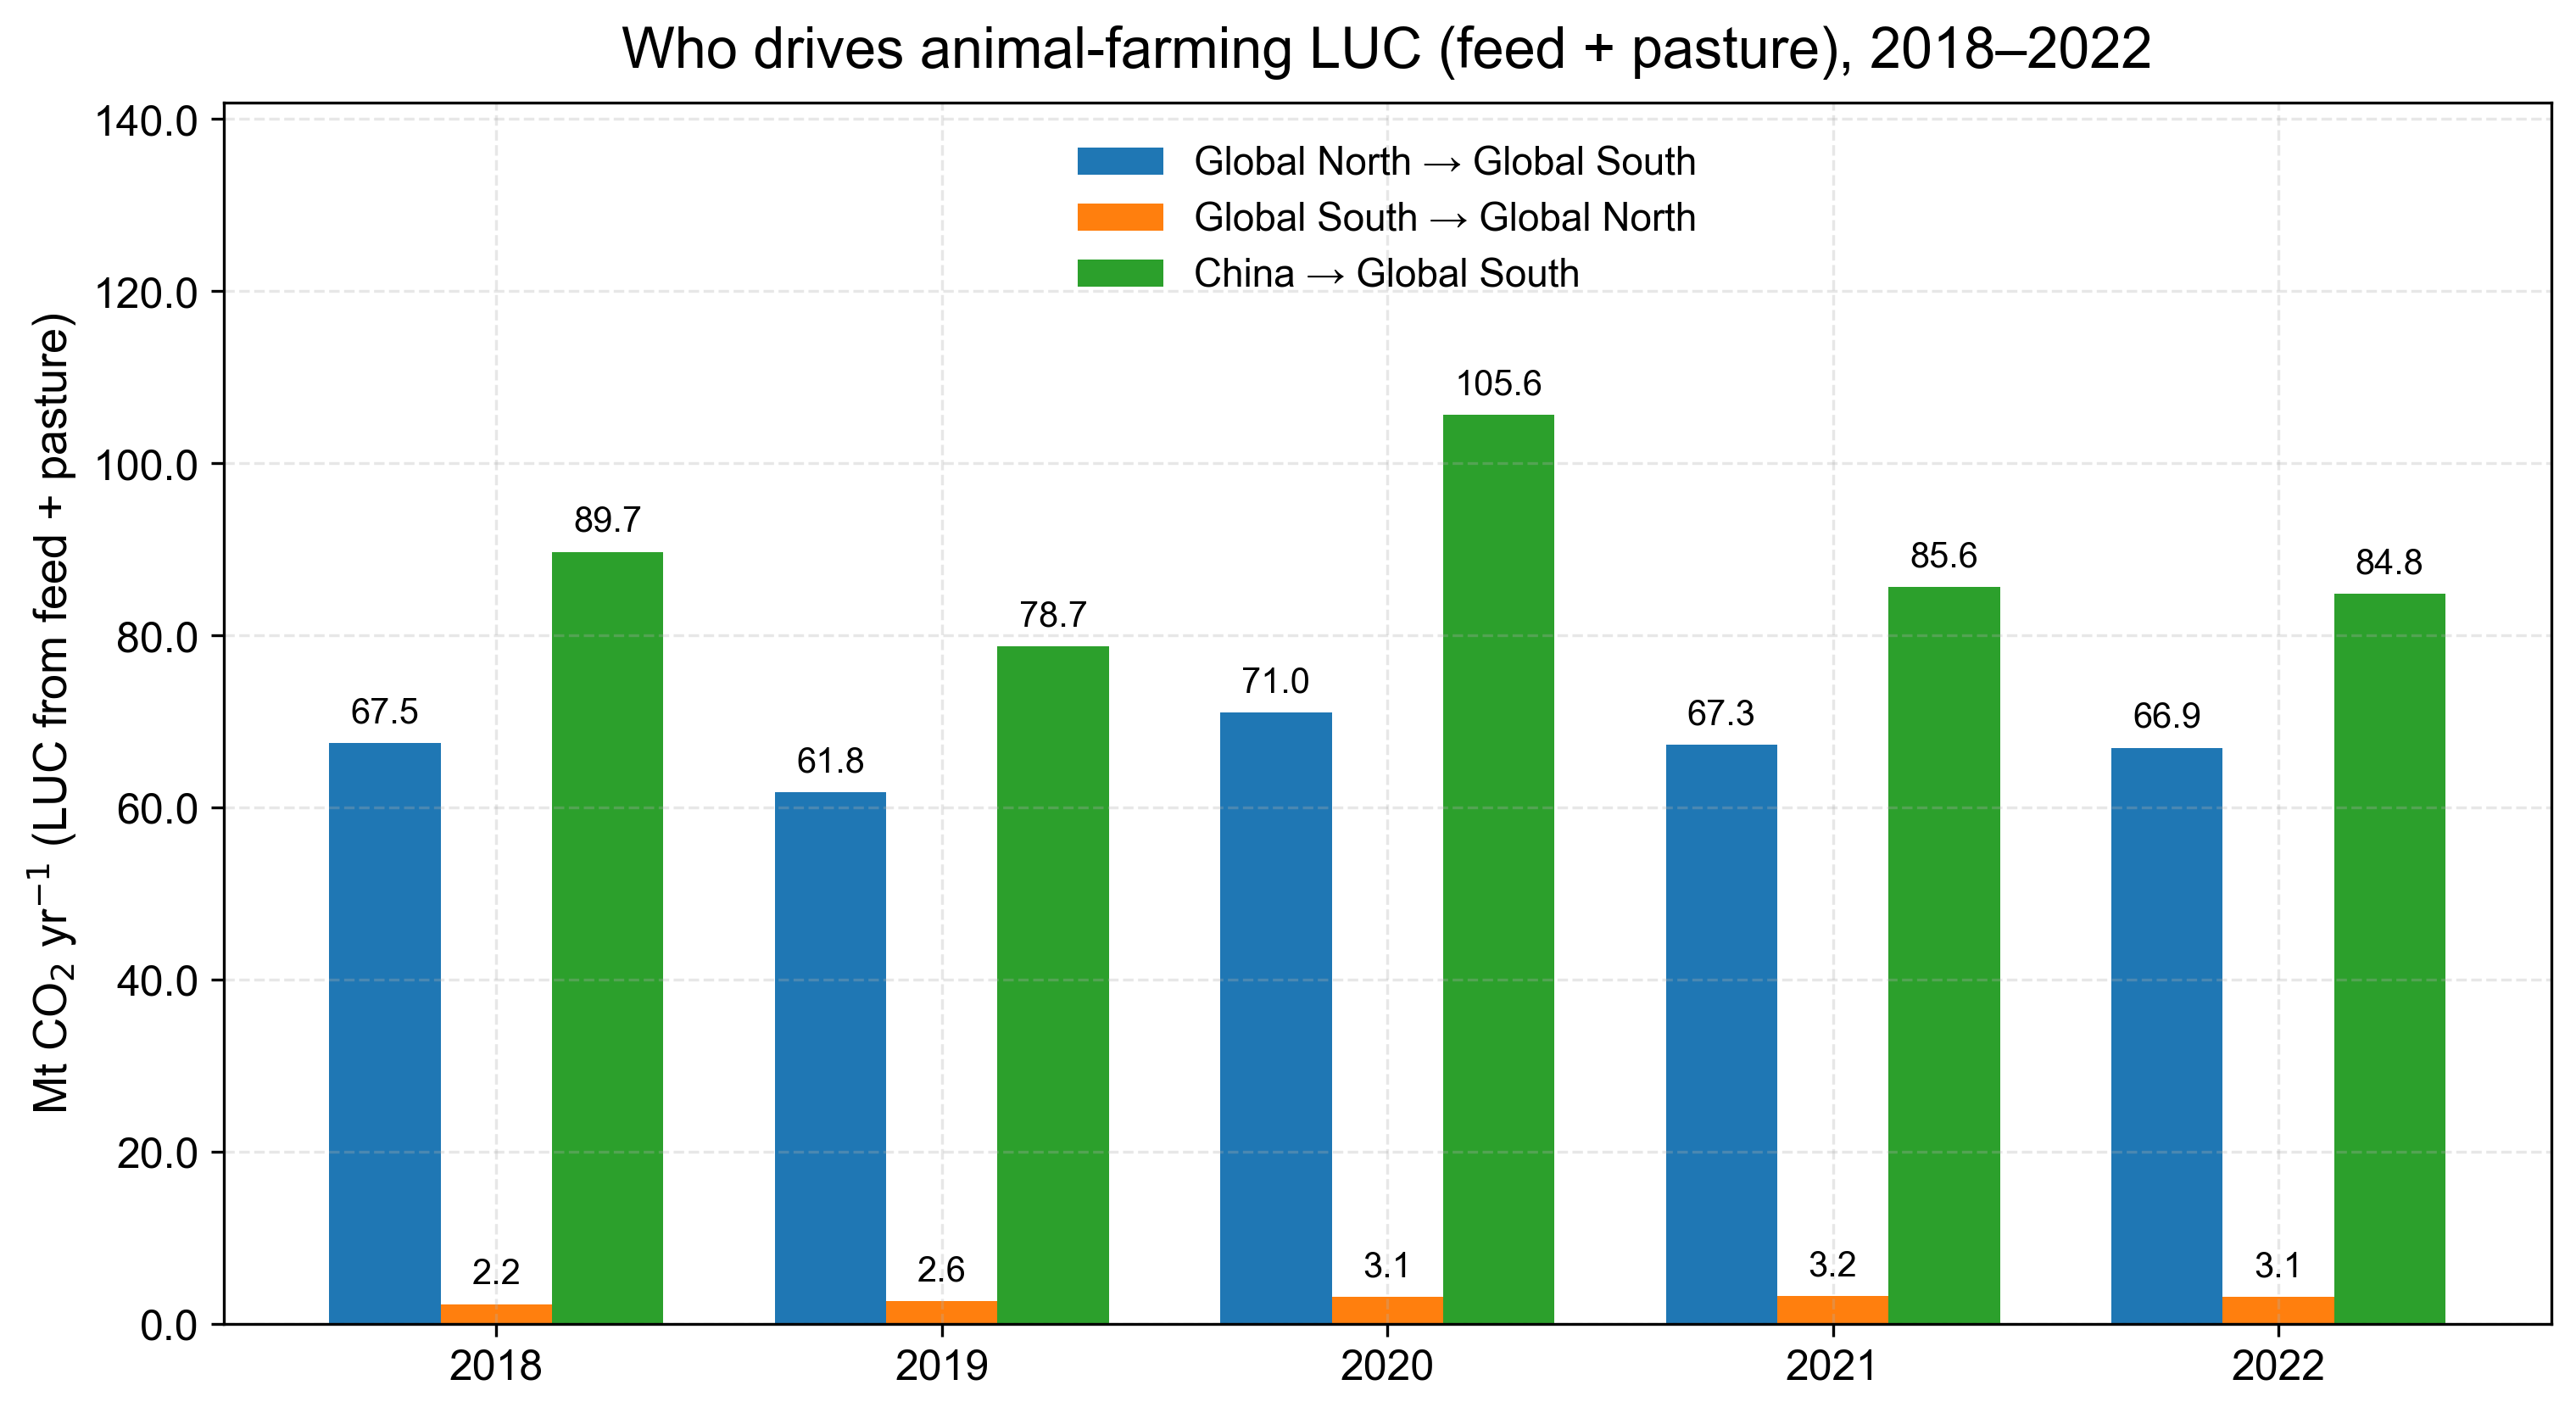

Saved: outputs/Fig_feed_pasture_total_LUC_flows_2018_2022.pdf | outputs/Fig_feed_pasture_total_LUC_flows_2018_2022.png


In [10]:
# 7.1 Main flows: Global North → Global South, etc.

years = wide_total.index.to_list()
x = np.arange(len(years))
bar_width = 0.25

flow_labels = {
    "GN→GS": "Global North → Global South",
    "GS→GN": "Global South → Global North",
    "CN→GS": "China → Global South",
}
flows = ["GN→GS","GS→GN","CN→GS"]

fig, ax = plt.subplots()

bars = []
for i, flow in enumerate(flows):
    if flow not in wide_total.columns:
        continue
    vals  = wide_total[flow].values
    label = flow_labels.get(flow, flow)
    offset = (i - 1) * bar_width  # positions: -w, 0, +w
    b = ax.bar(x + offset, vals, width=bar_width, label=label)
    bars.append(b)

# Annotate bar heights
for container in bars:
    for rect in container:
        h = rect.get_height()
        if np.isfinite(h):
            ax.annotate(f"{h:.1f}",
                        xy=(rect.get_x()+rect.get_width()/2, h),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha="center", va="bottom", fontsize=10)

ax.yaxis.set_major_formatter(FuncFormatter(fmt_mt))
ax.set_xticks(x)
ax.set_xticklabels([str(int(y)) for y in years])
ax.set_ylabel("Mt CO$_2$ yr$^{-1}$ (LUC from feed + pasture)")
ax.set_title("Who drives animal-farming LUC (feed + pasture), 2018–2022")

lo, hi = ax.get_ylim()
ax.set_ylim(lo, hi * 1.28)

place_legend(ax, ncols=1, loc="upper center")
tight_layout(fig)

pdf = OUT_DIR / "Fig_feed_pasture_total_LUC_flows_2018_2022.pdf"
png = OUT_DIR / "Fig_feed_pasture_total_LUC_flows_2018_2022.png"
fig.savefig(pdf, bbox_inches="tight")
fig.savefig(png, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", pdf, "|", png)